In [2]:
import torch
import torch.nn as nn
import numpy as np
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from dataclasses import dataclass, asdict
from simple_parsing import ArgumentParser
from medAI.modeling import LayerNorm2d, Patchify
import medAI
from einops import rearrange, repeat
import wandb
from tqdm import tqdm
import submitit
from medAI.datasets import (
            ExactNCT2013BModeImagesWithManualProstateSegmenation,
            CohortSelectionOptions,
            AlignedFilesDataset,
        )
import matplotlib.pyplot as plt
from medAI.utils.setup import basic_experiment_setup


In [3]:
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)
    
def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)   
    
def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))  


In [4]:


@dataclass
class Config:
    """Training configuration"""

    epochs: int = 5
    lr: float = 0.0001
    batch_size: int = 1
    # freeze_backbone: bool = True
    model_name: str = "medsam"
    wandb: bool = True
    debug: bool = False
    submitit: bool = False


def dice_loss(mask_probs, target_mask):
    intersection = (mask_probs * target_mask).sum()
    union = mask_probs.sum() + target_mask.sum()
    return 1 - 2 * intersection / union


def dice_score(mask_probs, target_mask):
    mask_probs = mask_probs > 0.5
    intersection = (mask_probs * target_mask).sum()
    union = mask_probs.sum() + target_mask.sum()
    return 2 * intersection / union


class Experiment:
    def __init__(self, config: Config):
        self.config = config
        self._config_dict = asdict(config)
        self.model = None
        self.train_loader = None
        self.optimizer = None

    def setup(self):
        self.env = basic_experiment_setup(
            config_dict=self._config_dict,
            project='finetune_medsam', 
            debug=self.config.debug,
            use_wandb=self.config.wandb,
        )
        train_ds = AlignedFilesDataset(
            split="train",
            transform=self.transform1,
        )
        train_ds = train_ds + ExactNCT2013BModeImagesWithManualProstateSegmenation(
            split="train",
            transform=self.transform2,
            cohort_selection_options=CohortSelectionOptions(),
        )
        train_ds = train_ds + ExactNCT2013BModeImagesWithManualProstateSegmenation(
            split="val",
            transform=self.transform2,
            cohort_selection_options=CohortSelectionOptions(),
        )
        
        test_datasets = {}
        test_datasets['aligned_files'] = AlignedFilesDataset(
            split="test",
            transform=lambda item: self.transform1(item, augment=False),
        )
        test_datasets['nct'] = ExactNCT2013BModeImagesWithManualProstateSegmenation(
            split="test",
            transform=lambda item: self.transform2(item),
            cohort_selection_options=CohortSelectionOptions(),
        )
        self.train_loader = DataLoader(
            train_ds, batch_size=self.config.batch_size, shuffle=True, num_workers=4
        )
        self.test_loaders = {
            name: DataLoader(
                test_ds, batch_size=self.config.batch_size, shuffle=False, num_workers=4
            )
            for name, test_ds in test_datasets.items()
        }

        self.model = MedSAMWithPromptsForFinetuning()
        self.model = self.model.cuda()
        self.optimizer = optim.Adam(self.model.parameters(), lr=self.config.lr)
        self.scheduler = medAI.utils.LinearWarmupCosineAnnealingLR(
            self.optimizer,
            warmup_epochs=5 * len(self.train_loader),
            max_epochs=self.config.epochs * len(self.train_loader),
        )
        print("Number of parameters: ", sum(p.numel() for p in self.model.parameters()))
        print(
            "Trainable parameters: ",
            sum(p.numel() for p in self.model.parameters() if p.requires_grad),
        )

    def transform1(self, item, augment=True):
        """Transforms for the aligned files dataset"""
        from torchvision import transforms as T
        
        from torchvision.transforms import InterpolationMode
        bmode = item["image"]
        bmode = T.ToTensor()(bmode)
        bmode = T.Resize((1024, 1024), antialias=True)(bmode)
        bmode = (bmode - bmode.min() ) / (bmode.max() - bmode.min())
        bmode = bmode.repeat(3, 1, 1)
        mask = item["mask"]
        mask = mask.astype("uint8")
        mask = T.ToTensor()(mask).float() 
        mask = T.Resize(
            (1024, 1024), antialias=False, interpolation=InterpolationMode.NEAREST
        )(mask)

        if augment: 
            bmode, mask = self.augment(bmode, mask)

        # label = torch.tensor(item["grade"] != "Benign").long()
        return bmode, mask

    def augment(self, bmode, mask): 
        from torchvision.datapoints import Mask
        from torchvision.transforms.v2 import RandomResizedCrop, RandomApply, Compose, RandomAffine
        import torchvision
        torchvision.disable_beta_transforms_warning()

        augmentation = Compose([
            RandomApply([RandomResizedCrop(1024, scale=(0.8, 1.0))], p=0.5),
            RandomApply([RandomAffine(0, translate=(0.2, 0.2))], p=0.3),
        ])
        bmode, mask = augmentation(bmode, Mask(mask))
        return bmode, mask

    def transform2(self, item):
        from torchvision import transforms as T
        from torchvision.transforms import InterpolationMode
        bmode = item["bmode"]
        bmode = np.flip(bmode, axis=0).copy()
        bmode = T.ToTensor()(bmode)
        bmode = T.Resize((1024, 1024), antialias=True)(bmode)
        bmode = (bmode - bmode.min() ) / (bmode.max() - bmode.min())
        bmode = bmode.repeat(3, 1, 1)
        mask = item["prostate_mask"]
        mask = np.flip(mask, axis=0).copy()
        mask = mask.astype("uint8")
        mask = T.ToTensor()(mask).float() * 255 
        
        mask = T.Resize(
            (1024, 1024), antialias=False, interpolation=InterpolationMode.NEAREST
        )(mask)
        return bmode, mask

    def run(self):
        self.setup()
        best_scores = {} 
        for self.epoch in range(self.config.epochs):
            print(f"Epoch {self.epoch}")
            self.train_epoch(self.model, self.optimizer, self.train_loader)
            for name, test_loader in self.test_loaders.items():
                score = self.eval_epoch(self.model, test_loader, name=name)
                if best_scores.get(name, 0) < score: 
                    best_scores[name] = score
                    torch.save(self.model.state_dict(), self.env.ckpt_dir / f"medsam_finetuned_{name}_dice_{score}.pth")
                     
    def train_epoch(self, model, optimizer, loader):
        model.train()

        dice = []
        for i, batch in enumerate(tqdm(loader)):
            score = self.model.training_step(batch, i, optimizer)
            dice.append(score)
            if i % 100 == 0:
                self.model.show_batch(batch)
                wandb.log(
                    {
                        "train_example": wandb.Image(
                            plt, caption=f"Epoch {self.epoch}, batch {i}"
                        )
                    }
                )
                plt.close()
            self.scheduler.step()
            wandb.log(
                {
                    "lr": self.scheduler.get_last_lr()[0],
                }
            )
            if self.config.debug and i > 10:
                break

        wandb.log(
            {
                "train_dice": sum(dice) / len(dice)
            }
        )

    @torch.no_grad()
    def eval_epoch(self, model, loader, name="test"):
        model.eval()
        dice = []
        for i, batch in enumerate(tqdm(loader)):
            dice.append(self.model.eval_step(batch))
            if i % 100 == 0:
                self.model.show_batch(batch)
                wandb.log(
                    {
                        f"{name}_example": wandb.Image(
                            plt, caption=f"Epoch {self.epoch}, batch {i}"
                        )
                    }
                )
                plt.close()
            if self.config.debug and i > 10:
                break

        wandb.log(
            {
                f"{name}_dice": sum(dice) / len(dice)
            }
        )
        return sum(dice) / len(dice)
    
    
class MedSAMWithPromptsForFinetuning(nn.Module): 
    def __init__(self): 
        super().__init__()
        from segment_anything import sam_model_registry
        self.medsam_model = sam_model_registry["vit_b"](
            checkpoint="/scratch/ssd004/scratch/pwilson/medsam_vit_b_cpu.pth"
        )
        for param in self.medsam_model.image_encoder.parameters(): 
            param.requires_grad = False
        for param in self.medsam_model.prompt_encoder.parameters():
            param.requires_grad = False
        for param in self.medsam_model.mask_decoder.parameters():
            param.requires_grad = True
            
        self.image_feats = None

    def forward(self, image, points: tuple[torch.Tensor, torch.Tensor] | None = None, reset_cache=True): 
        if self.image_feats is None or reset_cache: 
            with torch.no_grad():
                self.image_feats = self.medsam_model.image_encoder(image)
        image_feats = self.image_feats
        sparse_embedding, dense_embedding = self.medsam_model.prompt_encoder.forward(
            points, None, None
        )
        mask_logits = self.medsam_model.mask_decoder.forward(
            image_feats, self.medsam_model.prompt_encoder.get_dense_pe(), 
            sparse_embedding, dense_embedding, multimask_output=False
        )[0]
        return mask_logits

    def get_loss_and_score(self, mask_logits, gt_mask): 
        B, C, H, W = mask_logits.shape

        gt_mask = torch.nn.functional.interpolate(gt_mask.float(), size=(H, W))

        ce_loss = torch.nn.functional.binary_cross_entropy_with_logits(
            mask_logits, gt_mask
        )
        _dice_loss = dice_loss(mask_logits.sigmoid(), gt_mask)
        loss = ce_loss + _dice_loss

        _dice_score = dice_score(mask_logits.sigmoid(), gt_mask)
        return loss, _dice_score
        
    def training_step(self, batch, batch_idx, optimizer, n_point_samples=3): 
        X, y = batch 
        X = X.cuda()
        y = y.cuda()
        
        B, _, H, W = X.shape

        # first prediction
        try: 
            points = self.sample_coords_in_mask(y).to(X.device)
            point_labels = torch.ones_like(points[:, :, 0], device=points.device)
            mask_logits = self.forward(X, points=(points, point_labels))
        except: 
            # no points in the mask
            mask_logits = self.forward(X, points=None)
        loss, score = self.get_loss_and_score(mask_logits, y)
        loss.backward()

        wandb.log({"train_loss": loss.item(), "lr": optimizer.param_groups[0]['lr']})

        optimizer.step()
        optimizer.zero_grad()
        pred = mask_logits.sigmoid()
        pred = torch.nn.functional.interpolate(pred, size=(H, W))
        pred = (pred > 0.5).detach()
        y = y.detach()

        for I in range(1, n_point_samples):
        # next predictions - sample a point from the error
            try: 
                points, point_labels = self.sample_new_prompt_points(y, pred, points, point_labels)
                points = torch.cat([points, points], dim=1)
                point_labels = torch.cat([point_labels, point_labels], dim=1)
                mask_logits = self.forward(X, points=(points, point_labels), reset_cache=False)
            except:
                # no points in the mask
                mask_logits = self.forward(X, points=None)
            loss, _ = self.get_loss_and_score(mask_logits, y)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            pred = mask_logits.sigmoid()
            pred = torch.nn.functional.interpolate(pred, size=(H, W))
            pred = (pred > 0.5).detach()
            y = y.detach()

        return score.item()

    @torch.no_grad()
    def eval_step(self, batch): 
        X, y = batch 
        X = X.cuda()
        y = y.cuda()
        
        B, _, H, W = X.shape

        # first prediction
        points = self.sample_coords_in_mask(y).to(X.device)
        point_labels = torch.ones_like(points[:, :, 0], device=points.device)
        mask_logits = self.forward(X, points=(points, point_labels))
        loss, score = self.get_loss_and_score(mask_logits, y)
        pred = mask_logits.sigmoid()
        pred = torch.nn.functional.interpolate(pred, size=(H, W))
        pred = (pred > 0.5).detach()
        y = y.detach()
        return score.item()
        
    @torch.no_grad()
    def show_batch(self, batch, n_point_samples=3): 
        self.eval()
        X, y = batch 
        X = X.cuda()
        y = y.cuda()

        B, _, H, W = X.shape
        
        # first prediction
        try: 
            points = self.sample_coords_in_mask(y).to(X.device)
            point_labels = torch.ones_like(points[:, :, 0], device=points.device)
            mask_logits = self.forward(X, points=(points, point_labels))
            points_found = True
        except: 
            # no points in the mask
            mask_logits = self.forward(X, points=None)
            points_found = False
        loss, score = self.get_loss_and_score(mask_logits, y)
        pred = mask_logits.sigmoid()
        pred = torch.nn.functional.interpolate(pred, size=(H, W))
        pred = (pred > 0.5).detach()
        y = y.detach()

        fig, ax = plt.subplots(n_point_samples, 3, figsize=(15, 5 * n_point_samples))
        for ax_ in ax.flatten(): 
            ax_.axis('off')
        ax[0, 0].imshow(X[0, 0, :, :].detach().cpu().numpy())
        ax[0, 1].imshow(y[0, 0, :, :].detach().cpu().numpy())
        ax[0, 2].imshow(pred[0, 0, :, :].detach().cpu().numpy(), extent=[0, 1024, 1024, 0])
        points_np = points.detach().cpu().numpy()
        point_labels_np = point_labels.detach().cpu().numpy()
        if points_found:
            show_points(points_np[0], point_labels_np[0], ax[0, 1])
            show_points(points_np[0], point_labels_np[0], ax[0, 2])

        for I in range(1, n_point_samples):
        # second prediction - sample a point from the error
            try: 
                points, point_labels = self.sample_new_prompt_points(y, pred, points, point_labels)
                points = torch.cat([points, points], dim=1)
                point_labels = torch.cat([point_labels, point_labels], dim=1)
                mask_logits = self.forward(X, points=(points, point_labels), reset_cache=False)
                points_found = True
            except:
                # no points in the mask
                mask_logits = self.forward(X, points=None)
                points_found = False

            loss, score = self.get_loss_and_score(mask_logits, y)
            pred = mask_logits.sigmoid()
            pred = torch.nn.functional.interpolate(pred, size=(H, W))
            pred = (pred > 0.5).detach()
            y = y.detach()

            ax[I, 0].imshow(X[0, 0, :, :].detach().cpu().numpy())
            ax[I, 1].imshow(y[0, 0, :, :].detach().cpu().numpy())
            ax[I, 2].imshow(pred[0, 0, :, :].detach().cpu().numpy(), extent=[0, 1024, 1024, 0])
            points_np = points.detach().cpu().numpy()
            point_labels_np = point_labels.detach().cpu().numpy()
            if points_found:
                show_points(points_np[0], point_labels_np[0], ax[I, 1])
                show_points(points_np[0], point_labels_np[0], ax[I, 2])

    def sample_new_prompt_points(self, y, pred, old_coords, old_labels):
        B, C, H, W = y.shape
        y = y.long()
        pred = pred.long()
        there_but_not_predicted = (y - pred.float()).relu()
        predicted_but_not_there = (pred - y.float()).relu()
        
        masks_to_sample = []
        labels = []
        for i in range(B):
            # choosing whether to sample from the there_but_not_predicted or predicted_but_not_there - 
            # we want to sample more often from the one that has more points in the error
            prob_there = there_but_not_predicted[i].sum() / (there_but_not_predicted[i].sum() + predicted_but_not_there[i].sum())
            if np.random.random() < prob_there:
                masks_to_sample.append(there_but_not_predicted[i])
                labels.append(torch.tensor([1], device=y.device))
            else:
                masks_to_sample.append(predicted_but_not_there[i])
                labels.append(torch.tensor([0], device=y.device))
        masks_to_sample = torch.stack(masks_to_sample, dim=0)
        new_coords = self.sample_coords_in_mask(masks_to_sample)
        labels = torch.stack(labels, dim=0)
        coords = torch.cat([old_coords, new_coords], dim=1)
        labels = torch.cat([old_labels, labels], dim=1)
        return coords, labels

    def sample_coords_in_mask(self, mask):
        B, N, H, W = mask.shape

        y_flattened = mask.view(B, -1)

        Y, X = torch.meshgrid(torch.arange(H), torch.arange(W))
        X = X.flatten()
        Y = Y.flatten()
        XY = torch.stack([X, Y], dim=1)

        indices = torch.arange(y_flattened.shape[1], device=y_flattened.device)
        
        points = []
        for k in range(B): 
            valid_indices = indices[y_flattened[k] != 0].cpu().numpy()
            from numpy.random import choice
            idx = choice(valid_indices, size=1)
            ij = XY[idx]
            points.append(ij)
        points = torch.stack(points, dim=0)

        return points.to(mask.device)


In [5]:
os.environ["WANDB_MODE"] = "run"
exp = Experiment(Config(wandb=True))

In [6]:
exp.run()

ERROR:wandb.jupyter:Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: Currently logged in as: pfrwilson. Use `wandb login --relogin` to force relogin


Number of parameters:  93735472
Trainable parameters:  4058340
Epoch 0


  0%|          | 0/5614 [00:00<?, ?it/s]/h/pwilson/anaconda3/envs/ai/lib/python3.11/site-packages/torchvision/datapoints/__init__.py:12: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https://github.com/pytorch/vision/issues/6753, and you can also check out https://github.com/pytorch/vision/issues/7319 to learn more about the APIs that we suspect might involve future changes. You can silence this warning by calling torchvision.disable_beta_transforms_warning().
  warnings.warn(_BETA_TRANSFORMS_WARNING)
/h/pwilson/anaconda3/envs/ai/lib/python3.11/site-packages/torchvision/datapoints/__init__.py:12: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user

In [189]:
exp.run()

wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Number of parameters:  93735472
Trainable parameters:  93735472
Epoch 0


  0%|          | 0/5614 [00:00<?, ?it/s]/h/pwilson/anaconda3/envs/ai/lib/python3.11/site-packages/torchvision/datapoints/__init__.py:12: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https://github.com/pytorch/vision/issues/6753, and you can also check out https://github.com/pytorch/vision/issues/7319 to learn more about the APIs that we suspect might involve future changes. You can silence this warning by calling torchvision.disable_beta_transforms_warning().
  warnings.warn(_BETA_TRANSFORMS_WARNING)
/h/pwilson/anaconda3/envs/ai/lib/python3.11/site-packages/torchvision/datapoints/__init__.py:12: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user

ValueError: 'a' cannot be empty unless no samples are taken

/h/pwilson/anaconda3/envs/ai/lib/python3.11/site-packages/torchvision/datapoints/__init__.py:12: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https://github.com/pytorch/vision/issues/6753, and you can also check out https://github.com/pytorch/vision/issues/7319 to learn more about the APIs that we suspect might involve future changes. You can silence this warning by calling torchvision.disable_beta_transforms_warning().
  warnings.warn(_BETA_TRANSFORMS_WARNING)
/h/pwilson/anaconda3/envs/ai/lib/python3.11/site-packages/torchvision/datapoints/__init__.py:12: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback yo

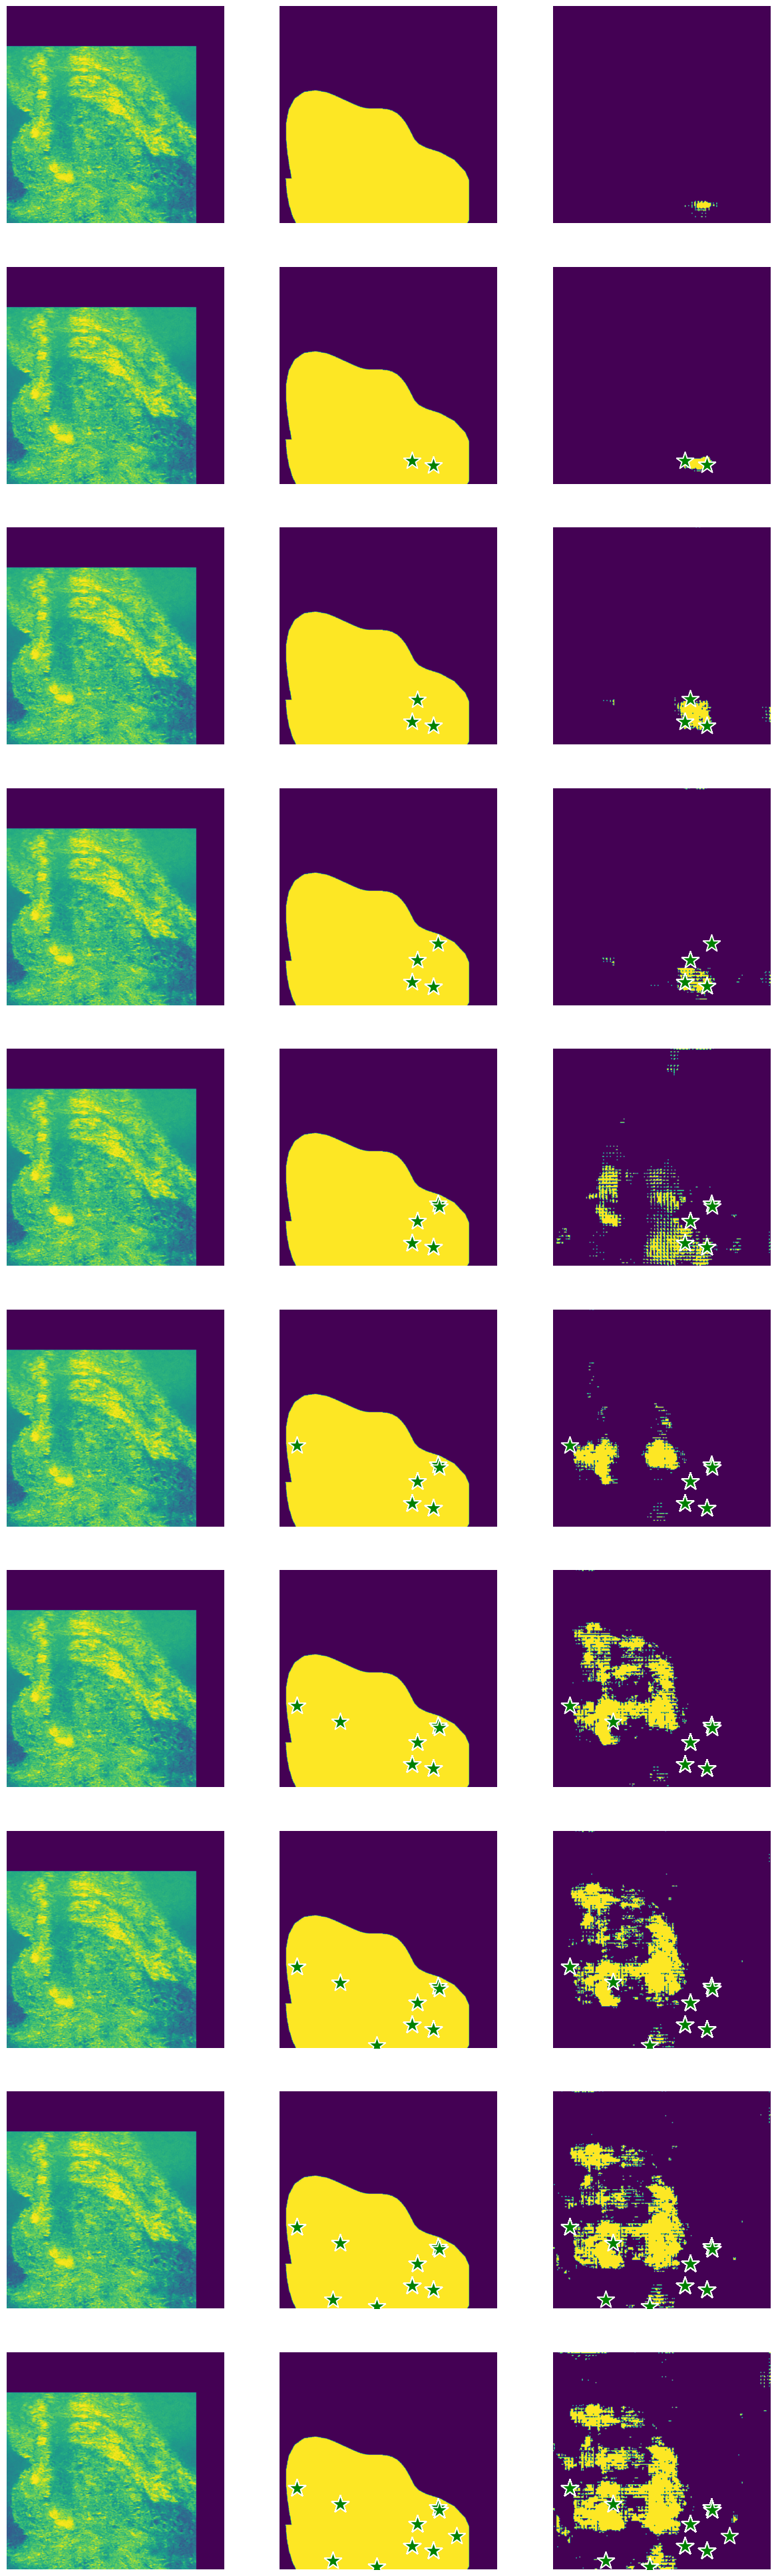

In [165]:
loader = exp.train_loader
batch = next(iter(loader))
exp.model.show_batch(batch, n_point_samples=10)

In [166]:
X, mask = next(iter(loader))
mask = (mask != 0).float()

/h/pwilson/anaconda3/envs/ai/lib/python3.11/site-packages/torchvision/datapoints/__init__.py:12: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https://github.com/pytorch/vision/issues/6753, and you can also check out https://github.com/pytorch/vision/issues/7319 to learn more about the APIs that we suspect might involve future changes. You can silence this warning by calling torchvision.disable_beta_transforms_warning().
  warnings.warn(_BETA_TRANSFORMS_WARNING)
/h/pwilson/anaconda3/envs/ai/lib/python3.11/site-packages/torchvision/datapoints/__init__.py:12: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback yo

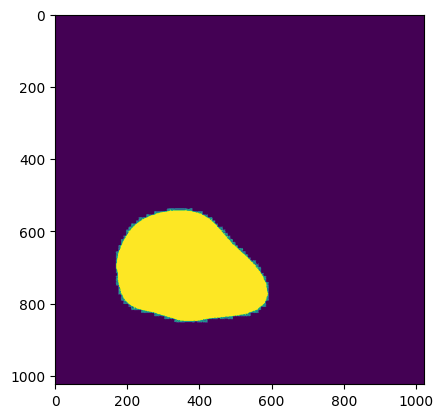

In [99]:
import matplotlib.pyplot as plt

plt.imshow(mask[0][0])

[741904]


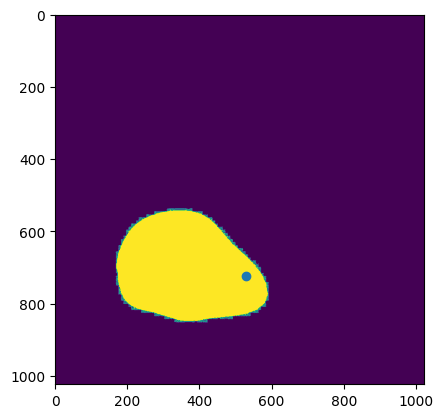

In [109]:
def sample_coords_in_mask(y):
    B, N, H, W = y.shape

    y_flattened = y.view(B, -1)

    X, Y = torch.meshgrid(torch.arange(H), torch.arange(W))
    X = X.flatten()
    Y = Y.flatten()
    XY = torch.stack([X, Y], dim=1)

    indices = torch.arange(y_flattened.shape[1], device=y_flattened.device)
    
    points = []
    for k in range(B): 
        valid_indices = indices[y_flattened[k] != 0].cpu().numpy()
        from numpy.random import choice
        idx = choice(valid_indices, size=1)
        print(idx)
        ij = XY[idx]
        points.append(ij)
    points = torch.stack(points, dim=0)

    return points



In [102]:
y_flattened.histogram()

torch.return_types.histogram(
hist=tensor([950462.,      0.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,      0.,      0.,      0.,      0.,      0.,      0.,
     

In [92]:
mask[0, 0, ij[0, 0], ij[0, 1]]

tensor(0.)

In [75]:
X.shape

torch.Size([1048576])

In [76]:
Y.shape

torch.Size([1048576])

In [74]:
y_flattened.shape

torch.Size([1, 1048576])

In [71]:
XY.shape

torch.Size([1048576, 2])

In [70]:
B

1

In [69]:
y_flattened

tensor([[0., 0., 0.,  ..., 0., 0., 0.]])

In [68]:
(mask.float() != mask).sum()

tensor(0)

In [63]:
XY

tensor([[   0,    0],
        [   0,    1],
        [   0,    2],
        ...,
        [1023, 1021],
        [1023, 1022],
        [1023, 1023]])

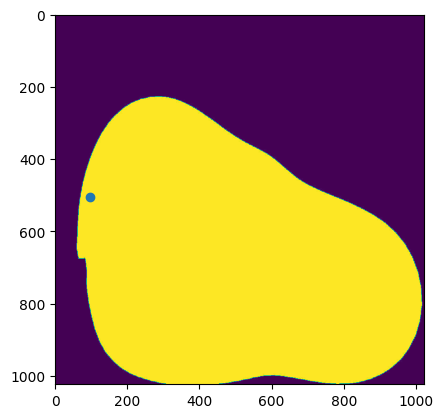

In [31]:
torch.meshgrid(torch.arange(H), torch.arange(W))

(tensor([[   0,    0,    0,  ...,    0,    0,    0],
         [   1,    1,    1,  ...,    1,    1,    1],
         [   2,    2,    2,  ...,    2,    2,    2],
         ...,
         [1021, 1021, 1021,  ..., 1021, 1021, 1021],
         [1022, 1022, 1022,  ..., 1022, 1022, 1022],
         [1023, 1023, 1023,  ..., 1023, 1023, 1023]]),
 tensor([[   0,    1,    2,  ..., 1021, 1022, 1023],
         [   0,    1,    2,  ..., 1021, 1022, 1023],
         [   0,    1,    2,  ..., 1021, 1022, 1023],
         ...,
         [   0,    1,    2,  ..., 1021, 1022, 1023],
         [   0,    1,    2,  ..., 1021, 1022, 1023],
         [   0,    1,    2,  ..., 1021, 1022, 1023]]))

In [24]:
H

1024

In [26]:
torch.arange(0, H).repeat([B, N, 1, H]).shape

torch.Size([1, 1, 1, 1048576])

In [11]:
import torch 

torch.multinomial()

def sample_point_prompt_inside_mask(mask): 
    B, N, H, W = mask.shape
    mask = mask.view(B, -1)
    

TypeError: multinomial() missing 2 required positional argument: "input", "num_samples"

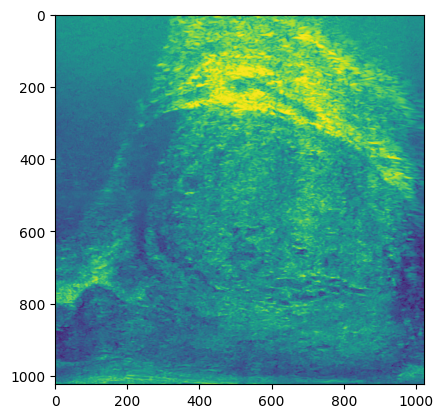

In [10]:

plt.imshow(X[0][0])
